# Logistic Regression to predict excess performance from EPS expectation performance

## Imports

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

## Data Loading

### Load CSV data for stock return
This was generated by [../excess_return_scripts/generate_data.sh](../excess_return_scripts/generate_data.sh).

In [2]:
training_data_output_frame = pd.read_csv(
    "../excess_return_scripts/training_data_output.csv",
    encoding="utf-8",
    encoding_errors="replace",
).set_index(["Symbol", "Date"])
training_return_output_frame = pd.read_csv(
    "../excess_return_scripts/training_return_output.csv",
    encoding="utf-8",
    encoding_errors="replace",
).set_index(["Symbol"])
validation_data_output_frame = pd.read_csv(
    "../excess_return_scripts/validation_data_output.csv",
    encoding="utf-8",
    encoding_errors="replace",
).set_index(["Symbol", "Date"])
validation_return_output_frame = pd.read_csv(
    "../excess_return_scripts/validation_return_output.csv",
    encoding="utf-8",
    encoding_errors="replace",
).set_index(["Symbol"])

In [3]:
training_data_output_frame.head()

Open        High         Low       Close   Adj Close  \
Symbol Date                                                                     
AAFRF  2024-02-01    1.390100    1.390100    1.390100    1.390100    1.390100   
       2024-02-02    1.390100    1.390100    1.390100    1.390100    1.390100   
       2024-02-05    1.380000    1.380000    1.380000    1.380000    1.380000   
       2024-02-06    1.380000    1.380000    1.380000    1.380000    1.380000   
AAPL   2024-02-01  183.990005  186.949997  183.820007  186.860001  186.621872   

                       Volume Effective Date Rate Type  Rate (%)  \
Symbol Date                                                        
AAFRF  2024-02-01         0.0            NaN       NaN       NaN   
       2024-02-02         0.0            NaN       NaN       NaN   
       2024-02-05       150.0            NaN       NaN       NaN   
       2024-02-06         0.0            NaN       NaN       NaN   
AAPL   2024-02-01  64885400.0            NaN       NaN       NaN   

                   1st Percentile (%)  ...  Target Rate To (%)  \
Symbol Date                            ...                       
AAFRF  2024-02-01                 NaN  ...                 NaN   
       2024-02-02                 NaN  ...                 NaN   
       2024-02-05                 NaN  ...                 NaN   
       2024-02-06                 NaN  ...                 NaN   
AAPL   2024-02-01                 NaN  ...                 NaN   

                   Intra Day - Low (%)  Intra Day - High (%)  \
Symbol Date                                                    
AAFRF  2024-02-01                  NaN                   NaN   
       2024-02-02                  NaN                   NaN   
       2024-02-05                  NaN                   NaN   
       2024-02-06                  NaN                   NaN   
AAPL   2024-02-01                  NaN                   NaN   

                   Standard Deviation (%)  30-Day Average SOFR  \
Symbol Date                                                      
AAFRF  2024-02-01                     NaN                  NaN   
       2024-02-02                     NaN                  NaN   
       2024-02-05                     NaN                  NaN   
       2024-02-06                     NaN                  NaN   
AAPL   2024-02-01                     NaN                  NaN   

                   90-Day Average SOFR  180-Day Average SOFR  SOFR Index  \
Symbol Date                                                                
AAFRF  2024-02-01                  NaN                   NaN         NaN   
       2024-02-02                  NaN                   NaN         NaN   
       2024-02-05                  NaN                   NaN         NaN   
       2024-02-06                  NaN                   NaN         NaN   
AAPL   2024-02-01                  NaN                   NaN         NaN   

                   Revision Indicator (Y/N)  Footnote ID  
Symbol Date                                               
AAFRF  2024-02-01                       NaN          NaN  
       2024-02-02                       NaN          NaN  
       2024-02-05                       NaN          NaN  
       2024-02-06                       NaN          NaN  
AAPL   2024-02-01                       NaN          NaN  

[5 rows x 25 columns]

In [4]:
training_return_output_frame.head()

,Unnamed: 0,Return,Market Return,Risk-Free Return,Excess Return
Symbol,,,,,
BY,0,0.004446,0.007140,0.000284,-0.002693
PROV,1,0.003311,0.006269,0.000568,-0.002958
CRNC,2,-0.166500,0.017562,0.000567,-0.184062
GWW,3,-0.033109,-0.000748,0.000284,-0.032361
FISI,4,0.015977,0.007140,0.000284,0.008838


In [5]:
validation_data_output_frame.head()

Open  High   Low  Close  Adj Close      Volume  \
Symbol Date                                                         
ABEV   2024-02-29  2.51  2.53  2.46   2.49       2.49  26744300.0   
       2024-03-01  2.50  2.51  2.44   2.48       2.48  40184500.0   
       2024-03-04  2.48  2.52  2.48   2.50       2.50   9388900.0   
       2024-03-05  2.55  2.57  2.53   2.55       2.55  15139000.0   
ABUS   2024-02-29  2.87  2.87  2.72   2.80       2.80   1066900.0   

                  Effective Date Rate Type  Rate (%)  1st Percentile (%)  ...  \
Symbol Date                                                               ...   
ABEV   2024-02-29            NaN       NaN       NaN                 NaN  ...   
       2024-03-01            NaN       NaN       NaN                 NaN  ...   
       2024-03-04            NaN       NaN       NaN                 NaN  ...   
       2024-03-05            NaN       NaN       NaN                 NaN  ...   
ABUS   2024-02-29            NaN       NaN       NaN                 NaN  ...   

                   Target Rate To (%)  Intra Day - Low (%)  \
Symbol Date                                                  
ABEV   2024-02-29                 NaN                  NaN   
       2024-03-01                 NaN                  NaN   
       2024-03-04                 NaN                  NaN   
       2024-03-05                 NaN                  NaN   
ABUS   2024-02-29                 NaN                  NaN   

                   Intra Day - High (%)  Standard Deviation (%)  \
Symbol Date                                                       
ABEV   2024-02-29                   NaN                     NaN   
       2024-03-01                   NaN                     NaN   
       2024-03-04                   NaN                     NaN   
       2024-03-05                   NaN                     NaN   
ABUS   2024-02-29                   NaN                     NaN   

                   30-Day Average SOFR  90-Day Average SOFR  \
Symbol Date                                                   
ABEV   2024-02-29                  NaN                  NaN   
       2024-03-01                  NaN                  NaN   
       2024-03-04                  NaN                  NaN   
       2024-03-05                  NaN                  NaN   
ABUS   2024-02-29                  NaN                  NaN   

                   180-Day Average SOFR  SOFR Index  Revision Indicator (Y/N)  \
Symbol Date                                                                     
ABEV   2024-02-29                   NaN         NaN                       NaN   
       2024-03-01                   NaN         NaN                       NaN   
       2024-03-04                   NaN         NaN                       NaN   
       2024-03-05                   NaN         NaN                       NaN   
ABUS   2024-02-29                   NaN         NaN                       NaN   

                   Footnote ID  
Symbol Date                     
ABEV   2024-02-29          NaN  
       2024-03-01          NaN  
       2024-03-04          NaN  
       2024-03-05          NaN  
ABUS   2024-02-29          NaN  

[5 rows x 25 columns]

In [6]:
validation_return_output_frame.head()

,Return,Market Return,Risk-Free Return,Excess Return
Symbol,,,,
HAYW,-0.062204,-0.001771,0.000426,-0.060433
DELL,0.243926,-0.001771,0.000426,0.245697
EPR,0.010467,-0.001771,0.000426,0.012239
RILY,0.148391,-0.001771,0.000426,0.150162
EE,-0.033121,-0.001771,0.000426,-0.031350


### Load JSON data for EPS

In [7]:
import json

training_earning_call_transcript_structured = json.load(
    open("../extract_data_scripts/training_earning_call_transcript_structured_with_sentiment.json")
)
validation_earning_call_transcript_structured = json.load(
    open("../extract_data_scripts/validation_earning_call_transcript_structured_with_sentiment.json")
)

In [8]:
import pprint

for items in training_earning_call_transcript_structured.items():
    pprint.pprint(items)
    break
for items in validation_earning_call_transcript_structured.items():
    pprint.pprint(items)
    break

('ACM',
 {'_ceo_avg_sentiment': 0.9352720557255312,
  '_ceo_max_sentiment': 0.9999141693115234,
  '_ceo_median_sentiment': 0.9993871450424194,
  '_ceo_min_sentiment': 0.00027631170814856887,
  '_ceo_paragraphs': ['Thank you, Will, and thank you all for joining us. Our '
                      'first quarter performance exceeded our expectations and '
                      "I'm very proud of how the organization is delivering on "
                      "our key priorities. We've established ourselves as the "
                      'trusted infrastructure consulting firm at a time when '
                      'funding is accelerating at an unprecedented pace across '
                      'our markets.',
                      'As a professional services organization, our people and '
                      'their passion to deliver a better world, create a '
                      'competitive advantage we bring to our clients. It is '
                      'through their unrivaled technica

## Data Preprocessing

In [9]:
training_csv_keys = training_return_output_frame.index
training_json_keys = training_earning_call_transcript_structured.keys()
training_keys = sorted(list(set(training_csv_keys) & set(training_json_keys)))
validation_csv_keys = validation_return_output_frame.index
validation_json_keys = validation_earning_call_transcript_structured.keys()
validation_keys = sorted(list(set(validation_csv_keys) & set(validation_json_keys)))
print(training_keys[:100])
print(validation_keys[:100])

['AAFRF', 'AAPL', 'ABCB', 'ACDSF', 'ACLS', 'ACM', 'ADDYY', 'ADP', 'AEIS', 'AFL', 'AGCO', 'AIT', 'AJG', 'ALFVF', 'ALGM', 'ALGN', 'ALGT', 'ALPMF', 'ALRS', 'ALV', 'AMAL', 'AMBFF', 'AMCR', 'AMD', 'AME', 'AMG', 'AMGN', 'AMKR', 'AMSC', 'AMTB', 'AMZN', 'AON', 'AOSL', 'APAM', 'APD', 'APPF', 'APTV', 'APYRF', 'ARAY', 'ARCB', 'ARE', 'ARLP', 'ARMK', 'ARWR', 'ASB', 'ASH', 'ASX', 'ATEYY', 'ATGE', 'ATHM', 'ATI', 'ATKR', 'AUDC', 'AVB', 'AVD', 'AVNW', 'AVT', 'AVY', 'AX', 'AXFOF', 'AXP', 'AXS', 'AXTA', 'AZEK', 'AZPN', 'BA', 'BAH', 'BALL', 'BANC', 'BAX', 'BBU', 'BBVA', 'BC', 'BCE', 'BCH', 'BDN', 'BDX', 'BEDU', 'BEN', 'BEP', 'BEPC', 'BFIN', 'BHE', 'BHLB', 'BIP', 'BKU', 'BMI', 'BMRC', 'BMY', 'BNDSF', 'BNPQF', 'BOOT', 'BOWL', 'BP', 'BR', 'BRBR', 'BRKL', 'BSAC', 'BSBR', 'BSIG']
['ABEV', 'ABUS', 'ACIC', 'ACIW', 'ACR', 'ADSK', 'ADV', 'AHT', 'AMPH', 'AMRN', 'AMWD', 'ANIP', 'ARGX', 'ARIS', 'ARLO', 'AVPT', 'BBWI', 'BBY', 'BCO', 'BIRK', 'BLFS', 'BMA', 'BRFH', 'BTE', 'BTSG', 'BUD', 'CAPR', 'CCOI', 'CELH', 'CERT', '

For now we only use one feature for the logistic regression - by how much EPS beat expectations.

In [10]:
X_training = []
Y_training = []
multiplier_dict = {"M": 1e6, "B": 1e9}
for i, symbol in enumerate(training_keys):
    expectation_results = training_earning_call_transcript_structured[symbol][
        "expectation_results"
    ]
    ceo_median_sentiment = training_earning_call_transcript_structured[symbol].get("_ceo_median_sentiment", np.nan)
    cfo_median_sentiment = training_earning_call_transcript_structured[symbol].get("_cfo_median_sentiment", np.nan)
    ceo_min_sentiment = training_earning_call_transcript_structured[symbol].get("_ceo_min_sentiment", np.nan)
    cfo_min_sentiment = training_earning_call_transcript_structured[symbol].get("_cfo_min_sentiment", np.nan)
    excess_return = float(training_return_output_frame.loc[symbol].get("Excess Return", np.nan))
    eps = float(expectation_results.get("eps", {}).get("value", np.nan))
    eps_beats_by = float(expectation_results.get("eps", {}).get("beats_by", np.nan))
    revenue = (
        float(expectation_results.get("revenue", {}).get("value", 'nanX')[:-1])
        * multiplier_dict.get(expectation_results.get("revenue", {}).get("value", "X")[-1], 1)
    )
    revenue_yoy = float(expectation_results.get("revenue", {}).get("YoY_percent", np.nan))
    revenue_beats_by = (
        float(expectation_results.get("revenue", {}).get("beats_by", "nanX")[:-1])
        * multiplier_dict.get(expectation_results.get("revenue", {}).get("value", "X")[-1], 1)
    )
    X_training.append((eps_beats_by, revenue_yoy, revenue_beats_by, ceo_median_sentiment, cfo_median_sentiment, ceo_min_sentiment, cfo_min_sentiment))
    Y_training.append(excess_return)
X_training_orig = np.array(X_training)
Y_training_orig = np.array(Y_training)
Y_training_classes_orig = np.where(Y_training_orig > 0, 1, 0)
X_training = X_training_orig.copy()
Y_training = Y_training_orig.copy()
Y_training_classes = Y_training_classes_orig.copy()
X_validation = []
Y_validation = []
for i, symbol in enumerate(validation_keys):
    expectation_results = validation_earning_call_transcript_structured[symbol][
        "expectation_results"
    ]
    ceo_median_sentiment = validation_earning_call_transcript_structured[symbol].get("_ceo_median_sentiment", np.nan)
    cfo_median_sentiment = validation_earning_call_transcript_structured[symbol].get("_cfo_median_sentiment", np.nan)
    ceo_min_sentiment = validation_earning_call_transcript_structured[symbol].get("_ceo_min_sentiment", np.nan)
    cfo_min_sentiment = validation_earning_call_transcript_structured[symbol].get("_cfo_min_sentiment", np.nan)
    excess_return = float(validation_return_output_frame.loc[symbol].get("Excess Return", np.nan))
    eps = float(expectation_results.get("eps", {}).get("value", np.nan))
    eps_beats_by = float(expectation_results.get("eps", {}).get("beats_by", np.nan))
    revenue = (
        float(expectation_results.get("revenue", {}).get("value", 'nanX')[:-1])
        * multiplier_dict.get(expectation_results.get("revenue", {}).get("value", "X")[-1], 1)
    )
    revenue_yoy = float(expectation_results.get("revenue", {}).get("YoY_percent", np.nan))
    revenue_beats_by = (
        float(expectation_results.get("revenue", {}).get("beats_by", "nanX")[:-1])
        * multiplier_dict.get(expectation_results.get("revenue", {}).get("value", "X")[-1], 1)
    )
    X_validation.append((eps_beats_by, revenue_yoy, revenue_beats_by, ceo_median_sentiment, cfo_median_sentiment, ceo_min_sentiment, cfo_min_sentiment))
    Y_validation.append(excess_return)
X_validation_orig = np.array(X_validation)
Y_validation_orig = np.array(Y_validation)
Y_validation_classes_orig = np.where(Y_validation_orig > 0, 1, 0)
X_validation = X_validation_orig.copy()
Y_validation = Y_validation_orig.copy()
Y_validation_classes = Y_validation_classes_orig.copy()

In [11]:
print(X_training_orig.shape)
print(X_validation_orig.shape)

(671, 7)
(161, 7)


In [20]:
Y_training_classes_orig[:100]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0])

In [21]:
Y_validation_classes_orig[:100]

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1])

Imputation: I've observed that reducing the number of training examples really reduces the effectiveness of the classifier. Therefore, we should impute missing data.

In [99]:
imp = IterativeImputer(missing_values=np.nan)
imp.fit(X_training_orig, Y_training_classes_orig)
X_training_imputed = imp.transform(X_training_orig)
X_validation_imputed = imp.transform(X_validation_orig)
Y_training_imputed = Y_training_orig.copy()
Y_training_classes_imputed = Y_training_classes_orig.copy()
Y_validation_imputed = Y_validation_orig.copy()
Y_validation_classes_imputed = Y_validation_classes_orig.copy()

Run this to just use expectation results as features

In [98]:
X_training_expectation = X_training_orig[:, :3]
print(X_training_expectation.shape)
nan_indices = np.where(np.isnan(X_training_expectation).any(axis=1))[0]
print(nan_indices)
X_training_expectation = np.delete(X_training_expectation, nan_indices, axis=0)
Y_training_expectation = np.delete(Y_training_orig, nan_indices, axis=0)
Y_training_classes_expectation = np.delete(Y_training_classes_orig, nan_indices, axis=0)
print(X_training_expectation.shape)
print(Y_training_expectation.shape)

X_validation_expectation = X_validation_orig[:, :3]
print(X_validation_expectation.shape)
nan_indices = np.where(np.isnan(X_validation_expectation).any(axis=1))[0]
print(nan_indices)
X_validation_expectation = np.delete(X_validation_expectation, nan_indices, axis=0)
Y_validation_expectation = np.delete(Y_validation_orig, nan_indices, axis=0)
Y_validation_classes_expectation = np.delete(Y_validation_classes_orig, nan_indices, axis=0)
print(X_validation_expectation.shape)
print(Y_validation_expectation.shape)


(671, 3)
[  0   3   6   8  13  17  18  21  22  32  37  38  40  43  47  52  54  59
  62  64  65  68  69  70  73  75  77  80  81  84  86  89  90  92  97  98
 103 107 113 118 122 129 131 135 138 139 140 146 154 162 165 168 172 175
 178 180 181 182 183 186 187 193 195 198 199 200 201 209 210 219 225 226
 233 235 243 247 249 250 257 269 272 277 279 280 282 283 291 292 296 297
 298 303 304 308 311 312 313 314 315 320 322 324 327 328 329 330 331 333
 335 336 337 342 343 344 347 348 351 353 354 355 356 358 360 365 366 369
 373 375 376 377 378 380 381 383 384 386 388 392 402 405 413 415 418 423
 427 432 434 435 436 438 439 440 442 446 450 453 455 458 460 461 468 470
 474 477 479 480 482 487 495 496 499 500 504 507 512 513 514 516 517 518
 520 523 530 532 537 538 540 541 542 544 545 549 551 555 564 568 569 570
 572 574 575 578 581 583 588 590 592 593 594 596 598 607 608 610 612 613
 615 622 623 624 625 630 633 635 638 639 641 651 652 655 657 659 661 662
 663 670]
(435, 3)
(435,)
(161, 3)
[  2   

Run this to just use sentiments as features

In [97]:
X_training_sentiment = X_training_orig[:, 3:]
print(X_training_sentiment.shape)
nan_indices = np.where(np.isnan(X_training_sentiment).any(axis=1))[0]
print(nan_indices)
X_training_sentiment = np.delete(X_training_sentiment, nan_indices, axis=0)
Y_training_sentiment = np.delete(Y_training_orig, nan_indices, axis=0)
Y_training_classes_sentiment = np.delete(Y_training_classes_orig, nan_indices, axis=0)
print(X_training_sentiment.shape)
print(Y_training_sentiment.shape)

X_validation_sentiment = X_validation_orig[:, 3:]
print(X_validation_sentiment.shape)
nan_indices = np.where(np.isnan(X_validation_sentiment).any(axis=1))[0]
print(nan_indices)
X_validation_sentiment = np.delete(X_validation_sentiment, nan_indices, axis=0)
Y_validation_sentiment = np.delete(Y_validation_orig, nan_indices, axis=0)
Y_validation_classes_sentiment = np.delete(Y_validation_classes_orig, nan_indices, axis=0)
print(X_validation_sentiment.shape)
print(Y_validation_sentiment.shape)


(671, 4)
[  3  11  17  40  46  49  52  54  57  64  69  74  80  81  90  96  97  99
 103 119 126 127 134 135 138 140 144 152 164 175 180 181 185 190 194 197
 199 205 208 213 217 219 233 237 239 247 250 251 262 269 276 279 283 285
 286 289 291 297 306 315 317 318 320 329 339 343 347 349 351 352 353 364
 367 372 375 380 383 387 391 392 398 399 402 405 416 418 420 425 427 430
 433 434 435 436 437 440 446 447 450 453 455 465 472 474 478 482 483 484
 487 490 493 496 498 500 504 513 516 518 520 526 530 537 538 541 545 546
 547 548 551 552 560 562 565 574 575 578 589 592 593 607 618 619 625 629
 634 647 652 653 655 660 670]
(520, 4)
(520,)
(161, 4)
[  0   2   7   8   9  12  18  20  21  23  24  32  34  35  43  45  47  48
  50  63  76  80  86  89  91  97 100 115 117 118 121 124 130 131 132 136
 152 155]
(123, 4)
(123,)


Run this to use expectation results and sentiments, but only where all data exists (no imputation)

In [96]:
X_training_combined = X_training_orig[:, :]
print(X_training_combined.shape)
nan_indices = np.where(np.isnan(X_training_combined).any(axis=1))[0]
print(nan_indices)
X_training_combined = np.delete(X_training_combined, nan_indices, axis=0)
Y_training_combined = np.delete(Y_training_orig, nan_indices, axis=0)
Y_training_classes_combined = np.delete(Y_training_classes_orig, nan_indices, axis=0)
print(X_training_combined.shape)
print(Y_training_combined.shape)

X_validation_combined = X_validation_orig[:, :]
print(X_validation_combined.shape)
nan_indices = np.where(np.isnan(X_validation_combined).any(axis=1))[0]
print(nan_indices)
X_validation_combined = np.delete(X_validation_combined, nan_indices, axis=0)
Y_validation_combined = np.delete(Y_validation_orig, nan_indices, axis=0)
Y_validation_classes_combined = np.delete(Y_validation_classes_orig, nan_indices, axis=0)
print(X_validation_combined.shape)
print(Y_validation_combined.shape)


(671, 7)
[  0   3   6   8  11  13  17  18  21  22  32  37  38  40  43  46  47  49
  52  54  57  59  62  64  65  68  69  70  73  74  75  77  80  81  84  86
  89  90  92  96  97  98  99 103 107 113 118 119 122 126 127 129 131 134
 135 138 139 140 144 146 152 154 162 164 165 168 172 175 178 180 181 182
 183 185 186 187 190 193 194 195 197 198 199 200 201 205 208 209 210 213
 217 219 225 226 233 235 237 239 243 247 249 250 251 257 262 269 272 276
 277 279 280 282 283 285 286 289 291 292 296 297 298 303 304 306 308 311
 312 313 314 315 317 318 320 322 324 327 328 329 330 331 333 335 336 337
 339 342 343 344 347 348 349 351 352 353 354 355 356 358 360 364 365 366
 367 369 372 373 375 376 377 378 380 381 383 384 386 387 388 391 392 398
 399 402 405 413 415 416 418 420 423 425 427 430 432 433 434 435 436 437
 438 439 440 442 446 447 450 453 455 458 460 461 465 468 470 472 474 477
 478 479 480 482 483 484 487 490 493 495 496 498 499 500 504 507 512 513
 514 516 517 518 520 523 526 530 532 537 5

In [24]:
Y_validation_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0])

## Create and train models

### Linear Regression Model (Ridge Regression)

In [406]:
ridge_pipe = make_pipeline(StandardScaler(), Ridge())
ridge_pipe.fit(X_training, Y_training)

Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())])

### Adaboost

In [117]:
weak_learner = tree.DecisionTreeClassifier(max_leaf_nodes=8)
n_estimators = 1000

adaboost_clf = AdaBoostClassifier(
    estimator=weak_learner,
    n_estimators=n_estimators,
    algorithm="SAMME",
).fit(X_training, Y_training_classes)

#### K-fold cross validation

In [121]:
param_grid = {
    'n_estimators': RoundedLogUniform(20, 1000),
    'learning_rate': scipy.stats.loguniform(1e-4, 1e0),
    'estimator__max_depth': [2]  # Only if tuning base estimator
}
weak_learner = tree.DecisionTreeClassifier()

adaboost_cv_clf_imputed = AdaBoostClassifier(
    estimator=weak_learner,
    algorithm='SAMME',
)
adaboost_cv_clf_imputed = RandomizedSearchCV(adaboost_cv_clf_imputed, param_grid, cv=5, scoring=['balanced_accuracy', 'f1_weighted'], refit='balanced_accuracy', n_jobs=1)
adaboost_cv_clf_imputed.fit(X_training_imputed, Y_training_classes_imputed)
# Extract and print the best parameters and the best score
best_params = adaboost_cv_clf_imputed.best_params_
best_score = adaboost_cv_clf_imputed.best_score_
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")
adaboost_cv_clf_combined = AdaBoostClassifier(
    estimator=weak_learner,
    algorithm='SAMME',
)
adaboost_cv_clf_combined = RandomizedSearchCV(adaboost_cv_clf_combined, param_grid, cv=5, scoring=['balanced_accuracy', 'f1_weighted'], refit='balanced_accuracy', n_jobs=1)
adaboost_cv_clf_combined.fit(X_training_combined, Y_training_classes_combined)
# Extract and print the best parameters and the best score
best_params = adaboost_cv_clf_combined.best_params_
best_score = adaboost_cv_clf_combined.best_score_
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'estimator__max_depth': 2, 'learning_rate': 0.0012838192572300192, 'n_estimators': 152}
Best score: 0.5042213883677298
Best parameters: {'estimator__max_depth': 2, 'learning_rate': 0.9816136144833622, 'n_estimators': 21}
Best score: 0.5511570613690008


### Gradient Boosting

In [99]:
n_estimators = 1000

gradboost_clf = GradientBoostingClassifier(
    n_estimators=n_estimators,
).fit(X_training, Y_training_classes)

#### K-fold cross validation

In [151]:
class RoundedLogUniform(scipy.stats.rv_discrete):
    def __init__(self, a=0, b=1):
        self._log_uniform = scipy.stats.loguniform(a, b)

    def rvs(self, size=None, random_state=None):
        samples = self._log_uniform.rvs(size=size, random_state=random_state)
        return np.round(samples).astype(int)

param_grid = {
    # 'clf__n_estimators': RoundedLogUniform(20, 500),
    # 'clf__learning_rate': scipy.stats.loguniform(1e-4, 1e-1),
    'n_estimators': RoundedLogUniform(20, 500),
    'learning_rate': scipy.stats.loguniform(1e-4, 1e-1),
}

#gradboost_cv_clf_imputed = Pipeline([('scaler', StandardScaler()), ('clf', GradientBoostingClassifier())])
gradboost_cv_clf_imputed = GradientBoostingClassifier()
gradboost_cv_clf_imputed = RandomizedSearchCV(gradboost_cv_clf_imputed, param_grid, cv=5, scoring=['balanced_accuracy', 'f1_weighted'], refit='balanced_accuracy', n_jobs=1)
gradboost_cv_clf_imputed.fit(X_training_imputed, Y_training_classes_imputed)
# Extract and print the best parameters and the best score
best_params = gradboost_cv_clf_imputed.best_params_
best_score = gradboost_cv_clf_imputed.best_score_
print("imputed")
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")
#gradboost_cv_clf_expectation = Pipeline([('scaler', StandardScaler()), ('clf', GradientBoostingClassifier())])
gradboost_cv_clf_expectation = GradientBoostingClassifier()
gradboost_cv_clf_expectation = RandomizedSearchCV(gradboost_cv_clf_expectation, param_grid, cv=5, scoring=['balanced_accuracy', 'f1_weighted'], refit='balanced_accuracy', n_jobs=1)
gradboost_cv_clf_expectation.fit(X_training_expectation, Y_training_classes_expectation)
# Extract and print the best parameters and the best score
best_params = gradboost_cv_clf_expectation.best_params_
best_score = gradboost_cv_clf_expectation.best_score_
print("expectation")
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")
#gradboost_cv_clf_sentiment = Pipeline([('scaler', StandardScaler()), ('clf', GradientBoostingClassifier())])
gradboost_cv_clf_sentiment = GradientBoostingClassifier()
gradboost_cv_clf_sentiment = RandomizedSearchCV(gradboost_cv_clf_sentiment, param_grid, cv=5, scoring=['balanced_accuracy', 'f1_weighted'], refit='balanced_accuracy', n_jobs=1)
gradboost_cv_clf_sentiment.fit(X_training_sentiment, Y_training_classes_sentiment)
# Extract and print the best parameters and the best score
best_params = gradboost_cv_clf_sentiment.best_params_
best_score = gradboost_cv_clf_sentiment.best_score_
print("sentiment")
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")
#gradboost_cv_clf_combined = Pipeline([('scaler', StandardScaler()), ('clf', GradientBoostingClassifier())])
gradboost_cv_clf_combined = GradientBoostingClassifier()
gradboost_cv_clf_combined = RandomizedSearchCV(gradboost_cv_clf_combined, param_grid, cv=5, scoring=['balanced_accuracy', 'f1_weighted'], refit='balanced_accuracy', n_jobs=1)
gradboost_cv_clf_combined.fit(X_training_combined, Y_training_classes_combined)
# Extract and print the best parameters and the best score
best_params = gradboost_cv_clf_combined.best_params_
best_score = gradboost_cv_clf_combined.best_score_
print("combined")
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

imputed
Best parameters: {'learning_rate': 0.04530118443011536, 'n_estimators': 308}
Best score: 0.5153060647844662
expectation
Best parameters: {'learning_rate': 0.00679537169126161, 'n_estimators': 82}
Best score: 0.5138023630504833
sentiment
Best parameters: {'learning_rate': 0.010499589064826991, 'n_estimators': 339}
Best score: 0.5282935571291196
combined
Best parameters: {'learning_rate': 0.034506629373860814, 'n_estimators': 136}
Best score: 0.5327871754523997


### Random Forest

In [50]:
n_estimators = 1000

randomforest_clf = RandomForestClassifier(
    n_estimators=n_estimators, max_features=None,
).fit(X_training, Y_training_classes)

### Decision Tree Classifier and Regression

In [355]:
dt_pipe = make_pipeline(tree.DecisionTreeClassifier(max_depth=10))
dt_pipe = dt_pipe.fit(X_training, Y_training_classes)
dtr_pipe = make_pipeline(StandardScaler(), tree.DecisionTreeRegressor(max_depth=10))
dtr_pipe = dtr_pipe.fit(X_training, Y_training)
dtr_pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor', DecisionTreeRegressor(max_depth=10))])

In [337]:
dt_pipe.steps[-1][1]

DecisionTreeClassifier(max_depth=10)

In [338]:
# plt.figure(figsize=(15, 10), dpi=300)
# tree.plot_tree(dt_pipe.steps[-1][1], feature_names=['eps', 'eps_beats_by', 'revenu'revenue_beats_by'])

### Logistic Regression Model

In [134]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_training_combined, Y_training_classes_combined)
pipe_imputed = make_pipeline(StandardScaler(), LogisticRegression())
pipe_imputed.fit(X_training_imputed, Y_training_classes_imputed)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

## Make Predictions

## Evaluate the model

### Decision Tree Classifier

In [ ]:
dt_pipe.score(X_validation, Y_validation_classes)

0.49473684210526314

In [ ]:
Y_dt_predict_classes = dt_pipe.predict(X_validation)
Y_dt_predict_classes

array([0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0])

In [391]:
dt_pipe_conf_matrix = confusion_matrix(Y_validation_classes, dt_pipe.predict(X_validation))
print("Confusion Matrix:\n", dt_pipe_conf_matrix)

# Classification Report
dt_pipe_class_report = classification_report(Y_validation_classes, dt_pipe.predict(X_validation))
print("\nClassification Report:\n", dt_pipe_class_report)

Confusion Matrix:
 [[33 22]
 [26 14]]

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.60      0.58        55
           1       0.39      0.35      0.37        40

    accuracy                           0.49        95
   macro avg       0.47      0.47      0.47        95
weighted avg       0.49      0.49      0.49        95



### Adaboost

In [113]:
print(adaboost_clf.score(X_validation, Y_validation_classes))

0.5093167701863354


In [114]:
X_validation[:, :3]

array([[ 0.00000000e+00, -7.64000000e+00, -4.89240000e+11],
       [ 0.00000000e+00, -6.56900000e+01, -2.71000000e+06],
       [ 1.38757426e-01,  3.08887355e+00,  2.47234248e+10],
       [ 1.38744065e-01,  3.08887349e+00,  2.47234248e+10],
       [-4.00000000e-02, -3.42000000e+00,  2.85000000e+06],
       [ 1.40000000e-01,  1.14600000e+01,  3.73800000e+10],
       [-7.00000000e-02, -2.09000000e+00, -5.12600000e+10],
       [ 9.40000000e-01,  7.60000000e-01, -1.18000000e+06],
       [-3.00000000e-02,  3.19100000e+01,  4.78000000e+06],
       [ 3.00000000e-02, -1.72100000e+01,  3.61000000e+06],
       [ 3.70000000e-01, -1.21900000e+01,  1.28700000e+07],
       [ 1.50000000e-01,  3.97100000e+01,  6.72000000e+06],
       [-4.20000000e-01,  1.29010000e+02,  5.31300000e+07],
       [ 5.00000000e-02,  2.56500000e+01,  7.46000000e+06],
       [ 1.38771694e-01,  3.08887362e+00,  2.47234248e+10],
       [ 1.38772060e-01,  3.08887362e+00,  2.47234248e+10],
       [ 1.90000000e-01,  8.00000000e-01

In [118]:
adaboost_clf_conf_matrix = confusion_matrix(Y_validation_classes, adaboost_clf.predict(X_validation))
print("Confusion Matrix:\n", adaboost_clf_conf_matrix)

# Classification Report
adaboost_clf_class_report = classification_report(Y_validation_classes, adaboost_clf.predict(X_validation))
print("\nClassification Report:\n", adaboost_clf_class_report)

Confusion Matrix:
 [[57 34]
 [48 22]]

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.63      0.58        91
           1       0.39      0.31      0.35        70

    accuracy                           0.49       161
   macro avg       0.47      0.47      0.47       161
weighted avg       0.48      0.49      0.48       161



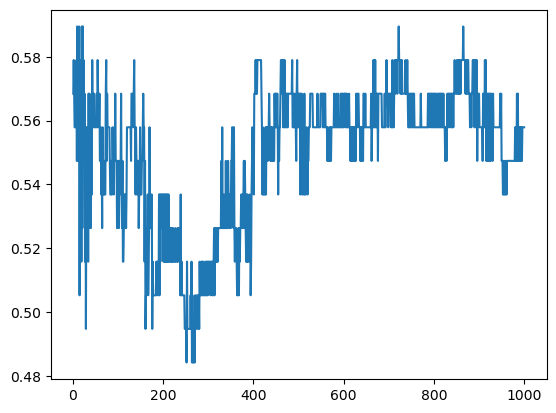

In [384]:

scores = list(adaboost_clf.staged_score(X_validation, Y_validation_classes))
iterations = range(1, len(scores) + 1)
plt.figure()
plt.plot(iterations, scores)

In [ ]:
adaboost_clf.predict_proba(X_validation)

array([[0.51000182, 0.48999818],
       [0.54943818, 0.45056182],
       [0.49598636, 0.50401364],
       [0.50215771, 0.49784229],
       [0.50819963, 0.49180037],
       [0.51158298, 0.48841702],
       [0.49904601, 0.50095399],
       [0.50669877, 0.49330123],
       [0.49800657, 0.50199343],
       [0.49251681, 0.50748319],
       [0.47417736, 0.52582264],
       [0.50079568, 0.49920432],
       [0.50590451, 0.49409549],
       [0.50166593, 0.49833407],
       [0.49671989, 0.50328011],
       [0.49943029, 0.50056971],
       [0.50564823, 0.49435177],
       [0.50028455, 0.49971545],
       [0.47705339, 0.52294661],
       [0.46663329, 0.53336671],
       [0.51045951, 0.48954049],
       [0.50195511, 0.49804489],
       [0.49899446, 0.50100554],
       [0.50255886, 0.49744114],
       [0.50324261, 0.49675739],
       [0.46988014, 0.53011986],
       [0.50483575, 0.49516425],
       [0.50680195, 0.49319805],
       [0.50483575, 0.49516425],
       [0.50147185, 0.49852815],
       [0.

#### K-fold cross-validation

In [124]:

print(adaboost_cv_clf_imputed.score(X_validation_imputed, Y_validation_classes_imputed))
print(adaboost_cv_clf_combined.score(X_validation_imputed, Y_validation_classes_imputed))


0.5087912087912088
0.5285714285714286


In [125]:

adaboost_cv_clf_imputed_conf_matrix = confusion_matrix(Y_validation_classes_imputed, adaboost_cv_clf_imputed.predict(X_validation_imputed))
print("Confusion Matrix:\n", adaboost_cv_clf_imputed_conf_matrix)

# Classification Report
adaboost_cv_clf_imputed_class_report = classification_report(Y_validation_classes_imputed, adaboost_cv_clf_imputed.predict(X_validation_imputed))
print("\nClassification Report:\n", adaboost_cv_clf_imputed_class_report)

adaboost_cv_clf_combined_conf_matrix = confusion_matrix(Y_validation_classes_imputed, adaboost_cv_clf_combined.predict(X_validation_imputed))
print("Confusion Matrix:\n", adaboost_cv_clf_combined_conf_matrix)

# Classification Report
adaboost_cv_clf_combined_class_report = classification_report(Y_validation_classes_imputed, adaboost_cv_clf_combined.predict(X_validation_imputed))
print("\nClassification Report:\n", adaboost_cv_clf_combined_class_report)

Confusion Matrix:
 [[90  1]
 [68  2]]

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.99      0.72        91
           1       0.67      0.03      0.05        70

    accuracy                           0.57       161
   macro avg       0.62      0.51      0.39       161
weighted avg       0.61      0.57      0.43       161

Confusion Matrix:
 [[52 39]
 [36 34]]

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.57      0.58        91
           1       0.47      0.49      0.48        70

    accuracy                           0.53       161
   macro avg       0.53      0.53      0.53       161
weighted avg       0.54      0.53      0.54       161



### Gradient Boosting

In [128]:
print(gradboost_cv_clf.score(X_validation, Y_validation_classes))

-0.6896033652928137


In [129]:
gradboost_cv_clf_conf_matrix = confusion_matrix(Y_validation_classes, gradboost_cv_clf.predict(X_validation))
print("Confusion Matrix:\n", gradboost_cv_clf_conf_matrix)


# Classification Report
gradboost_cv_clf_class_report = classification_report(Y_validation_classes, gradboost_cv_clf.predict(X_validation))
print("\nClassification Report:\n", gradboost_cv_clf_class_report)

Confusion Matrix:
 [[91  0]
 [70  0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.57      1.00      0.72        91
           1       0.00      0.00      0.00        70

    accuracy                           0.57       161
   macro avg       0.28      0.50      0.36       161
weighted avg       0.32      0.57      0.41       161



/Users/rmi1/.local/miniconda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rmi1/.local/miniconda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rmi1/.local/miniconda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

#### K-fold cross-validation

In [152]:

print(gradboost_cv_clf_imputed.score(X_validation_imputed, Y_validation_classes_imputed))
print(gradboost_cv_clf_expectation.score(X_validation_imputed[:, :3], Y_validation_classes_imputed))
print(gradboost_cv_clf_sentiment.score(X_validation_imputed[:, 3:], Y_validation_classes_imputed))
print(gradboost_cv_clf_combined.score(X_validation_imputed, Y_validation_classes_imputed))

print(gradboost_cv_clf_imputed.score(X_validation_combined, Y_validation_classes_combined))
print(gradboost_cv_clf_expectation.score(X_validation_combined[:, :3], Y_validation_classes_combined))
print(gradboost_cv_clf_sentiment.score(X_validation_combined[:, 3:], Y_validation_classes_combined))
print(gradboost_cv_clf_combined.score(X_validation_combined, Y_validation_classes_combined))


0.5027472527472527
0.515934065934066
0.46428571428571425
0.5153846153846153
0.5222222222222223
0.5222222222222223
0.4166666666666667
0.5222222222222223


In [153]:
#gradboost_cv_clf_imputed.best_estimator_[-1].feature_importances_
gradboost_cv_clf_imputed.best_estimator_.feature_importances_

array([0.12237508, 0.13953853, 0.17291735, 0.1654716 , 0.15212873,
       0.14732198, 0.10024673])

In [155]:

gradboost_cv_clf_imputed_imputed_conf_matrix = confusion_matrix(Y_validation_classes_imputed, gradboost_cv_clf_imputed.predict(X_validation_imputed))
print("Confusion Matrix:\n", gradboost_cv_clf_imputed_imputed_conf_matrix)
# Classification Report
gradboost_cv_clf_imputed_imputed_class_report = classification_report(Y_validation_classes_imputed, gradboost_cv_clf_imputed.predict(X_validation_imputed))
print("\nClassification Report:\n", gradboost_cv_clf_imputed_imputed_class_report)

gradboost_cv_clf_expectation_imputed_conf_matrix = confusion_matrix(Y_validation_classes_imputed, gradboost_cv_clf_expectation.predict(X_validation_imputed[:, :3]))
print("Confusion Matrix:\n", gradboost_cv_clf_expectation_imputed_conf_matrix)
# Classification Report
gradboost_cv_clf_expectation_imputed_class_report = classification_report(Y_validation_classes_imputed, gradboost_cv_clf_expectation.predict(X_validation_imputed[:, :3]))
print("\nClassification Report:\n", gradboost_cv_clf_expectation_imputed_class_report)

gradboost_cv_clf_sentiment_imputed_conf_matrix = confusion_matrix(Y_validation_classes_imputed, gradboost_cv_clf_sentiment.predict(X_validation_imputed[:, 3:]))
print("Confusion Matrix:\n", gradboost_cv_clf_sentiment_imputed_conf_matrix)
# Classification Report
gradboost_cv_clf_sentiment_imputed_class_report = classification_report(Y_validation_classes_imputed, gradboost_cv_clf_sentiment.predict(X_validation_imputed[:, 3:]))
print("\nClassification Report:\n", gradboost_cv_clf_sentiment_imputed_class_report)

gradboost_cv_clf_combined_imputed_conf_matrix = confusion_matrix(Y_validation_classes_imputed, gradboost_cv_clf_combined.predict(X_validation_imputed))
print("Confusion Matrix:\n", gradboost_cv_clf_combined_imputed_conf_matrix)
# Classification Report
gradboost_cv_clf_combined_imputed_class_report = classification_report(Y_validation_classes_imputed, gradboost_cv_clf_combined.predict(X_validation_imputed))
print("\nClassification Report:\n", gradboost_cv_clf_combined_imputed_class_report)

Confusion Matrix:
 [[72 19]
 [55 15]]

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.79      0.66        91
           1       0.44      0.21      0.29        70

    accuracy                           0.54       161
   macro avg       0.50      0.50      0.47       161
weighted avg       0.51      0.54      0.50       161

Confusion Matrix:
 [[90  1]
 [67  3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.99      0.73        91
           1       0.75      0.04      0.08        70

    accuracy                           0.58       161
   macro avg       0.66      0.52      0.40       161
weighted avg       0.65      0.58      0.45       161

Confusion Matrix:
 [[78 13]
 [65  5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.86      0.67        91
           1       0.28      0.07      0.11     

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have predicted probabilities and true labels for both test and validation sets
# For demonstration purposes, let's create some random data
test_labels = [0, 1, 1, 0, 1, 0, 1, 0]
test_probs = [0.1, 0.3, 0.4, 0.2, 0.6, 0.8, 0.7, 0.5]

val_labels = [0, 1, 0, 1, 0, 1, 1, 0]
val_probs = [0.2, 0.4, 0.1, 0.7, 0.3, 0.9, 0.6, 0.5]

# Compute ROC curve and ROC area for each class
fpr_test, tpr_test, _ = roc_curve(test_labels, test_probs)
roc_auc_test = auc(fpr_test, tpr_test)

fpr_val, tpr_val, _ = roc_curve(val_labels, val_probs)
roc_auc_val = auc(fpr_val, tpr_val)

# Plot ROC curve
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot(fpr_val, tpr_val, color='blue', lw=2, label=f'Validation ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

### Random Forest

In [51]:
print(randomforest_clf.score(X_validation, Y_validation_classes))

0.4666666666666667


In [52]:
randomforest_clf_conf_matrix = confusion_matrix(Y_validation_classes, randomforest_clf.predict(X_validation))
print("Confusion Matrix:\n", randomforest_clf_conf_matrix)


# Classification Report
randomforest_clf_class_report = classification_report(Y_validation_classes, randomforest_clf.predict(X_validation))
print("\nClassification Report:\n", randomforest_clf_class_report)

Confusion Matrix:
 [[26 19]
 [21  9]]

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.58      0.57        45
           1       0.32      0.30      0.31        30

    accuracy                           0.47        75
   macro avg       0.44      0.44      0.44        75
weighted avg       0.46      0.47      0.46        75



### Logistic regression classifier

In [135]:
print(pipe.score(X_validation_imputed, Y_validation_classes_imputed))
print(pipe.score(X_validation_combined, Y_validation_classes_combined))
print(pipe_imputed.score(X_validation_imputed, Y_validation_classes_imputed))
print(pipe_imputed.score(X_validation_combined, Y_validation_classes_combined))

0.5714285714285714
0.6
0.5590062111801242
0.5733333333333334


In [136]:
# Confusion Matrix
conf_matrix = confusion_matrix(Y_validation_classes_imputed, pipe.predict(X_validation_imputed))
print("Confusion Matrix:\n", conf_matrix)
# Classification Report
class_report = classification_report(Y_validation_classes_imputed, pipe.predict(X_validation_imputed))
print("\nClassification Report:\n", class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_validation_classes_combined, pipe.predict(X_validation_combined))
print("Confusion Matrix:\n", conf_matrix)
# Classification Report
class_report = classification_report(Y_validation_classes_combined, pipe.predict(X_validation_combined))
print("\nClassification Report:\n", class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_validation_classes_imputed, pipe_imputed.predict(X_validation_imputed))
print("Confusion Matrix:\n", conf_matrix)
# Classification Report
class_report = classification_report(Y_validation_classes_imputed, pipe_imputed.predict(X_validation_imputed))
print("\nClassification Report:\n", class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_validation_classes_combined, pipe_imputed.predict(X_validation_combined))
print("Confusion Matrix:\n", conf_matrix)
# Classification Report
class_report = classification_report(Y_validation_classes_combined, pipe_imputed.predict(X_validation_combined))
print("\nClassification Report:\n", class_report)

Confusion Matrix:
 [[80 11]
 [58 12]]

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.88      0.70        91
           1       0.52      0.17      0.26        70

    accuracy                           0.57       161
   macro avg       0.55      0.53      0.48       161
weighted avg       0.55      0.57      0.51       161

Confusion Matrix:
 [[41  4]
 [26  4]]

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.91      0.73        45
           1       0.50      0.13      0.21        30

    accuracy                           0.60        75
   macro avg       0.56      0.52      0.47        75
weighted avg       0.57      0.60      0.52        75

Confusion Matrix:
 [[89  2]
 [69  1]]

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.98      0.71        91
           1       0.33      0.01      0.03     

### Decision Tree Regression

In [ ]:
dtr_pipe.score(X_validation, Y_validation)

-5.118719157814237

### Ridge regression

In [ ]:
ridge_pipe.score(X_validation, Y_validation)

-0.03949537172620965

## Scratch space for experimentation

In [ ]:
# display = DecisionBoundaryDisplay.from_estimator(
#     pipe, X_validation
# )

In [ ]:
def plot(x, y, theta, save_path, correction=1.0):
    """Plot dataset and fitted logistic regression parameters.

    Args:
        x: Matrix of training examples, one per row.
        y: Vector of labels in {0, 1}.
        theta: Vector of parameters for logistic regression model.
        save_path: Path to save the plot.
        correction: Correction factor to apply (Problem 2(e) only).
    """
    # Plot dataset
    plt.figure()
    plt.plot(x[y == 1, -2], x[y == 1, -1], "bx", linewidth=2)
    plt.plot(x[y == 0, -2], x[y == 0, -1], "go", linewidth=2)

    # Plot decision boundary (found by solving for theta^T x = 0)
    x1 = np.arange(min(x[:, -2]), max(x[:, -2]), 0.01)
    x2 = -(theta[0] / theta[2] * correction + theta[1] / theta[2] * x1)
    plt.plot(x1, x2, c="red", linewidth=2)

    # Add labels and save to disk
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.savefig(save_path)

0.07103605819788694 0.08712929970154071
0.4236547993389047 0.6458941130666561
0.02021839744032572 0.832619845547938
0.5680445610939323 0.925596638292661
0.4375872112626925 0.8917730007820798


Text(0, 0.5, 'Y')

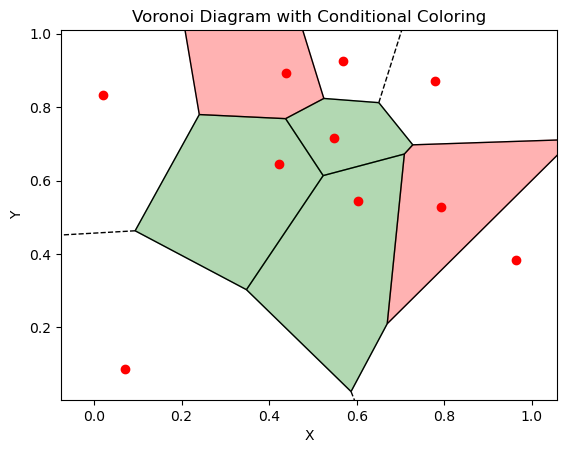

In [353]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np

# Generating random points
np.random.seed(0)
points = np.random.rand(10, 2)

# Creating Voronoi diagram
vor = Voronoi(points)

# Plotting Voronoi diagram
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=False)

# Plotting original points
plt.plot(points[:, 0], points[:, 1], 'ro')

# Check condition for each region
for region_index in vor.point_region:
    region = vor.regions[region_index]
    if -1 not in region:
        vertices = [vor.vertices[i] for i in region]
        x, y = points[region_index]
        print(x, y)
        if np.sin(30 * x * y) > 0:
            ax.fill(*zip(*vertices), color='green', alpha=0.3)
        else:
            ax.fill(*zip(*vertices), color='red', alpha=0.3)

plt.title('Voronoi Diagram with Conditional Coloring')
plt.xlabel('X')
plt.ylabel('Y')


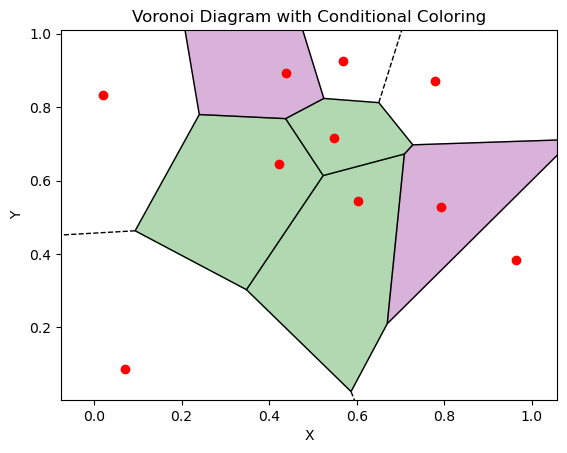

In [354]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np

# Generating random points
np.random.seed(0)
points = np.random.rand(10, 2)

# Creating Voronoi diagram
vor = Voronoi(points)

# Plotting Voronoi diagram
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=False)

# Plotting original points
plt.plot(points[:, 0], points[:, 1], 'ro')

# Check condition for each region
for region_index in vor.point_region:
    region = vor.regions[region_index]
    if -1 not in region:
        vertices = [vor.vertices[i] for i in region]
        outside = any(x < ax.get_xlim()[0] or x > ax.get_xlim()[1] or y < ax.get_ylim()[0] or y > ax.get_ylim()[1] for x, y in vertices)
        if outside:
            ax.fill(*zip(*vertices), color='purple', alpha=0.3)
        else:
            centroid = np.mean(vertices, axis=0)
            x, y = centroid
            if np.sin(x * y) > 0:
                ax.fill(*zip(*vertices), color='green', alpha=0.3)
            else:
                ax.fill(*zip(*vertices), color='red', alpha=0.3)

plt.title('Voronoi Diagram with Conditional Coloring')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
